In [43]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
from scipy.interpolate import LSQUnivariateSpline
from scipy import stats
import emcee
import csv

First lets define a function that will be used in the rest of the code

In [44]:
def robust_mean(x):
    # function that computes the robust mean of a vector, useful to bin the folded light curves
    valuestd = np.std(x)
    epsilon = 1.0
    while epsilon > 0.00001:
        goodp = np.abs(x-np.mean(x)) < 3.0*valuestd
        x = x[goodp]
        newstd = np.std(x)
        epsilon = np.abs((newstd-valuestd)/valuestd)
        valuestd = newstd
    return np.mean(x)

Now we read the data from the Readdingdata folder, which basically downloads the data and reads the flux measurements corrected with principal component analysis and eliminating the poor quality observations

In [45]:
data = pd.read_csv('./Readingdata/PDCMAP.csv')
time = np.array(data['Time'])
flux = np.array(data['Flux'])
quarter = np.array(data['Quarter'])

I define a few properties of the planet and the star, some of them will be fixed during the computations, some others not

In [46]:
## Planet properties
depth = 0.000174 #initial guess
period =  0.6892099 #initial guess
t0 = 53.191352 #initial guess
b = 0.5 #initial guess

ecc = 0.0 # fixed because orbital period is very short (circularization)

##Star properties (from Ellen)
mass = 1.00
masserr = 0.04
radius = 1.09
radiuserr = 0.09
u1 = 0.44 #Claret
u2 = 0.24 #Claret
diffLD = u1-u2

# Kepler cadence
tKep = 29.42/(60.0*24.0)

allfixed = [period, ecc,  mass, masserr, radius, radiuserr, diffLD, tKep]

Here I filter the effects of stellar activity on the long term behavior of the stellar flux using a cubic spline, with the transits masked out to avoid biasing the interpolation

In [47]:
goodquart = np.unique(quarter) # The set of Kepler quarters for which we have data

ndays = 6.0*period # Length of the spline equal to 6 times the orbital period

dt = time-t0 
phase = (dt % period)/period
movephase = phase > 0.5
phase[movephase] = phase[movephase]-1.0 #phase is now the orbital phase

transitwindow = 2.0/(24*period)
selectedp = np.abs(phase) > transitwindow #points with no transit


# Filter the observations within each quarter
for i in goodquart:
    goodp = quarter == i
    t = time[goodp]
    f = iniflux[goodp]
    oot = selectedp[goodp]

    knot_w = ndays 
    first_knot_i = np.where((t - t[0]) >= ndays*1.0)[0][0]
    last_knot_i = np.where((t[-1]-t) >= ndays*1.0)[0][-1]

    knots = np.arange(t[first_knot_i],t[last_knot_i],knot_w) # Set the knots of the spline
    spline = LSQUnivariateSpline(t[oot],f[oot],knots,k=3)  # Cubic-spline fit
    fit = spline(t) # Interpolate to the values inside of the transits too

    flux[goodp] = flux[goodp]/fit  #Corrected flux

Now I fold the light curve using the best fit period and t0 from Sanchis-Ojeda et al. 2014

1.90188648526e-05


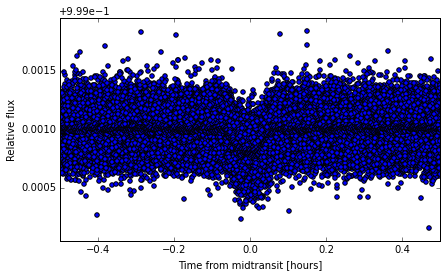

In [48]:
bin_means, bin_edges, binnumber = stats.binned_statistic(phase, flux, 
            statistic=robust_mean, bins = np.round(period*24.0*60.0)) # automatic binning according to orbital phase
bin_centers = 0.5*(bin_edges[0:-1] + bin_edges[1:])

# Plot the results
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(phase,flux)
plt.xlim([-0.5, 0.5]) 
plt.ylim([1-depth*5.5, depth*5.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.scatter(bin_centers, bin_means) 

selectedp = np.abs(bin_centers) < transitwindow
errorLC = np.std(bin_means[~selectedp]) # uncertainties meausred outside of transit
print errorLC

timeLC = period*bin_centers[selectedp]
fluxLC = bin_means[selectedp]

Here I define a likelihood function that will help me find the best transit parameters and their uncertainties

In [49]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model 
    given the following free parameters:
    
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter 
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
    
    And the following fixed parameter:
    allfixed[0] = period   orbital period in days
    allfixed[1] = ecc      orbital eccentricity
    allfixed[2] = mass     central value of the stellar mass gaussian prior 
    allfixed[3] = masserr  standard deviation of the stellar mass gaussian prior 
    allfixed[4] = radius     central value of the stellar radius gaussian prior 
    allfixed[5] = radiuserr  standard deviation of the stellar radius gaussian prior 
    allfixed[6] = u1-u2    difference between the limb darkening coefficients 
    allfixed[7] = tKep      cadence of the Kepler observations 
    
    The rest of the inputs are:
    
    timeLC: time from mid-transit in units of days (time series-data)
    fluxLC: normalized stellar flux (time series-data)
    errorLC: first guess for the uncertainty on the stellar fluxes
    """
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed
    u1 = 0.5*(sumLD+diffLD)
    u2 = sumLD-u1
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius ))
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period=period, t0=pt0, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    ftheo = ftheo-1+f0
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

A now I define an auxiliary function to add priors to the free parameters, and define a final function (lnprob) that will be the cost function to minimize to obtain the final parameters

In [50]:
def lnprior(theta):
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    if (0.4 < sumLD < 1.0) and (0 <= pb <1.0) and (0 <= sigma):
        return 0.0
    return -np.inf

In [51]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

Here I use the scipy.optimize package with the function minimize and the Nelder-Mead method to minimize the cost function

In [52]:
nll = lambda *args: -lnprob(*args)
result = op.minimize(nll, [1.2*depth, b, 0.0, 0.0, 0.6, mass, radius, 1.0], 
                     args=(timeLC, fluxLC, errorLC, allfixed), options={'disp': True}, method='Nelder-Mead')
depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]
u1_ml = 0.5*(sumLD_ml + diffLD)
u2_ml = sumLD_ml-u1_ml

Optimization terminated successfully.
         Current function value: -2486.421395
         Iterations: 984
         Function evaluations: 1486


Now I compute the light curve integrated over a Kepler long cadence exposure time to plot it with the data.

In [53]:
s = transit.System(transit.Central(mu1=u1_ml, mu2=u2_ml, mass = mass_ml, radius = radius_ml ))
body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=t0_ml, b=b_ml, e=ecc)
s.add_body(body)
t = np.arange(-1, 1, tKep*0.01)
f = s.light_curve(t, texp=tKep, tol=1e-08, maxdepth=4)
f = f-1.0 + f0_ml

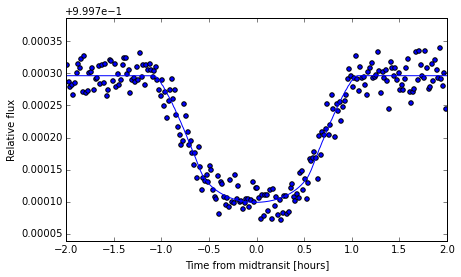

In [54]:
# Plot the results
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(24.0*timeLC,fluxLC)
plt.xlim([-2.0, 2.0]) 
plt.ylim([1-depth*1.5, depth*0.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.plot(24.0*t, f)

Here are the best fit parameters from this initial fit

In [55]:
depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml

(0.00016250684194386926,
 0.4093034455854514,
 -0.00040658565419403054,
 2.7010041865934395e-06,
 0.8245160237511211,
 1.0005084398336419,
 1.0830530723502809)

With the best fit solution, we can know obtain a folded light curve for each quarter and obtain a transit time that will be later used to update the orbital ephemeris. For that, we fixed most of the transit parameters and allow only 4 free parameters on the lnlikeind function

In [56]:
allfixed2 = [period, ecc, diffLD, tKep, depth_ml, b_ml, sumLD_ml, mass_ml, radius_ml]
print allfixed2

[0.6892099, 0.0, 0.2, 0.020430555555555556, 0.00016250684194386926, 0.4093034455854514, 0.8245160237511211, 1.0005084398336419, 1.0830530723502809]


In [ ]:
def lnlikeind(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following free parameters:
    theta[0] = pt0 = the time of transit of the folded light curve
    theta[1] = sigma = an additional white noise term
    theta[2] = f0 = the out of eclipse flux
    theta[3] = df_dt = the out of eclipse flux slope
    
    And the following fixed parameter:
    allfixed[0] = period   orbital period in days
    allfixed[1] = ecc      orbital eccentricity
    allfixed[2] = u1-u2    difference between the limb darkening coefficients 
    allfixed[3] = tKep      cadence of the Kepler observations 
    allfixed[4] = pdepth    (Rp/Rs)^2
    allfixed[5] = pb       the impact parameter 
    allfixed[6] = u1+u2    sum of the limb darkening coefficients 
    allfixed[7] = pmass     value of the stellar mass
    allfixed[8] = pradius   value of the stellar radius 
    
    The rest of the inputs are:
    
    timeLC: time from mid-transit in units of days (time series-data)
    fluxLC: normalized stellar flux (time series-data)
    errorLC: first guess for the uncertainty on the stellar fluxes
    
    """
    pt0, sigma, f0, df_dt = theta
    period, ecc,diffLD, tKep, pdepth, pb, sumLD,  pmass, pradius = allfixed
    u1 = 0.5*(sumLD+diffLD)
    u2 = sumLD-u1
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius ))
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period=period, t0=pt0, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    ftheo = ftheo-1+f0
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)))

Now we create a folded light curve in each quarter, fit the data with the model describe above, and obtain a best fit time of transit. Uncertainties are obtained with a MCMC routine (emcee).

In [ ]:
epochs = [] #  Mean Orbital number for each quarter of observations
timeoftrans = []  # Time of transit at the mean orbit
uncertainty = []  # Associated time of transit uncertainty

fig = plt.figure(figsize=(15,15))

numplots = 0

for quart in goodquart:
    if quart > 1 and quart < 17: # Quarters 0, 1 and 17 are shorter and have poorer precisin
        selp = quarter == quart
        approxt = np.median(time[selp])
        theepoch= np.round((approxt-t0)/period)
        prelimt0 = theepoch*period + t0
        newdt = time[selp]-t0 
        phase = (newdt % period)/period
        movephase = phase > 0.5
        phase[movephase] = phase[movephase]-1.0

        bin_means, bin_edges, binnumber = stats.binned_statistic(phase, flux[selp], statistic='median',
                                                         bins = np.round(period*24.0*60.0)) #folded light curve
        bin_centers = 0.5*(bin_edges[0:-1] + bin_edges[1:])
        selectedp = np.abs(bin_centers) < 1.5*transitwindow
        errorLC = np.nanstd(bin_means[~selectedp]) # outside of transit

        timeLC = period*bin_centers[selectedp]
        fluxLC = bin_means[selectedp]
        
        
        timeLC = timeLC[~np.isnan(fluxLC)]
        fluxLC = fluxLC[~np.isnan(fluxLC)]

        goodp= fluxLC < 1.0 + 3.0*errorLC #Removing clear outliers
        timeLC = timeLC[goodp]
        fluxLC = fluxLC[goodp]
        
        
        
        nll = lambda *args: -lnlikeind(*args)
        result = op.minimize(nll, [0.0, 0.01*errorLC,1.0, 0.0000001], 
                     args=(timeLC, fluxLC, errorLC, allfixed2), options={'disp': True}, method='Nelder-Mead')
        t0_ml, sigma_ml, f0_ml, df_dt_ml  = result["x"] #Best fit parameters

        # Best fit model light curve for the plot
        s = transit.System(transit.Central(mu1=u1_ml, mu2=u2_ml, mass = mass_ml, radius = radius_ml ))
        body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=t0_ml, b=b_ml, e=ecc)
        s.add_body(body)
        t = np.arange(-1, 1, tKep*0.01)
        f = s.light_curve(t, texp=tKep, tol=1e-08, maxdepth=4)
        f = f-1.0 + f0_ml + df_dt_ml*t
        
        # Plot of the data and the model
        numplots +=1    
        ax = fig.add_subplot(4,5,numplots)
        ax.scatter(24.0*timeLC, fluxLC)
        plt.xlim([-3.0, 3.0]) 
        plt.ylim([1-depth*2.5, depth*1.5+1]) 
        ax.plot(24.0*t, f)
        
        # MCMC estimate of the uncertainties using emcee, with 4 dimensions and 50 walkers
        ndim, nwalkers = 4, 50
        pos = [result["x"]*(1+1e-3*np.random.randn(ndim)) for i in range(nwalkers)]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlikeind, args=(timeLC, fluxLC, errorLC, allfixed2))
        sampler.run_mcmc(pos, 1000)
        samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) #Burn in portion to remove (currently %10)
        
        t0_mcmc, sigma_mcmc, f0_mcmc, df_dt_mcmc = map(lambda v: 
            (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0))) # Confidence levels

        epochs.extend([theepoch])
        timeoftrans.extend([prelimt0+t0_mcmc[0]])
        uncertainty.extend([0.5*(t0_mcmc[1]+t0_mcmc[2])])

        
print epochs
print timeoftrans

Optimization terminated successfully.
         Current function value: -3145.406684
         Iterations: 58
         Function evaluations: 107
Optimization terminated successfully.
         Current function value: -3197.619418
         Iterations: 44
         Function evaluations: 86
Optimization terminated successfully.

Now we can fit the timings to obtain the final epoch using the uncertainties and the scipy.optimize.curve_fit routine

In [ ]:
values, covariancemetric = op.curve_fit(lambda x, a, b: x*a +b, epochs, timeoftrans, sigma=uncertainty)
newperiod = values[0]
newperioderr = np.sqrt(covariancemetric[0, 0])
newt0 = values[1]
newt0err = np.sqrt(covariancemetric[1, 1])

residuals = timeoftrans-np.array(epochs)*values[0]-values[1]

# Plot the results
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.errorbar(timeoftrans,24.0*60.0*(residuals), yerr=np.array(uncertainty)*24.0*60.0)
plt.xlim([0, 1500]) 
ax.set_xlabel('Time KBJD')
ax.set_ylabel('0-C minutes')


print newperiod, newperioderr
print newt0, newt0err

Here we save the transit times to a csv file

In [ ]:
f1 = open("Transittimes.csv", "wb")
ttimes = csv.writer(f1)
ttimes.writerow(["Epoch", "TransitTime", "Uncertainty"])

for j, thetime in enumerate(timeoftrans):
    entries = [epochs[j], thetime, uncertainty[j]]
    ttimes.writerow(entries)

    
f1.close()

We can now generate a new folded light curve with the best fit orbital period and t0, and the previously filtered light curve

In [ ]:
dt = np.array(time-newt0)
phase = np.array((dt % newperiod)/newperiod)
movephase = phase > 0.5
phase[movephase] = phase[movephase]-1.0

bin_means, bin_edges, binnumber = stats.binned_statistic(phase, flux, statistic=robust_mean,
                                                         bins = np.round(period*24.0*60.0))

bin_centers = 0.5*(bin_edges[0:-1] + bin_edges[1:])
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(phase,flux)
plt.xlim([-0.5, 0.5]) 
plt.ylim([1-depth*5.5, depth*5.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.scatter(bin_centers, bin_means) 

transitwindow = 2.0/(24*period)
selectedp = np.abs(bin_centers) < transitwindow
errorLC = np.std(bin_means[~selectedp]) # outside of transit

print errorLC

timeLC = period*bin_centers[selectedp]
fluxLC = bin_means[selectedp]

And save it to a csv file

In [ ]:
f1 = open("LCdata.csv", "wb")
folded = csv.writer(f1)
folded.writerow(["Time", "Flux"])

for j, time in enumerate(timeLC):
    entries = [time, fluxLC[j]]
    folded.writerow(entries)

    
f1.close()

Finally we can save the orbital ephemeris with uncertainties in a file

In [ ]:
f1 = open("finaltransitephemeris.csv", "wb")
ephe = csv.writer(f1)
ephe.writerow(["Orbital period", "Unc", "Time of transit", "Unc"])
entries = [newperiod, newperioderr, newt0, newt0err]
ephe.writerow(entries)
f1.close()